/var/folders/j3/pj3kpjws5gj32d8zrny204340000gn/T/ipykernel_30867/3577912609.py:23: DtypeWarning: Columns (10,22,29,31,32,35,36,40,44,45,46,48,51,54,65,84,89,90,93,98,99,100,105,108,115,118,122,123,125,130,134,138,142,143,144,146,149,152,163,166,167,171,172,173,175,178,181,192,194,225,271,272,273,277,304,315,321,325,330,331,335,336,342,348,369,371,373,374,376,380,384,387,403,405,407,409) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Number of unique materials in ETL_stack_sequence: 513


/var/folders/j3/pj3kpjws5gj32d8zrny204340000gn/T/ipykernel_30867/3577912609.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', num_layers) if num_layers <= 10 else cm.get_cmap('tab20', num_layers)


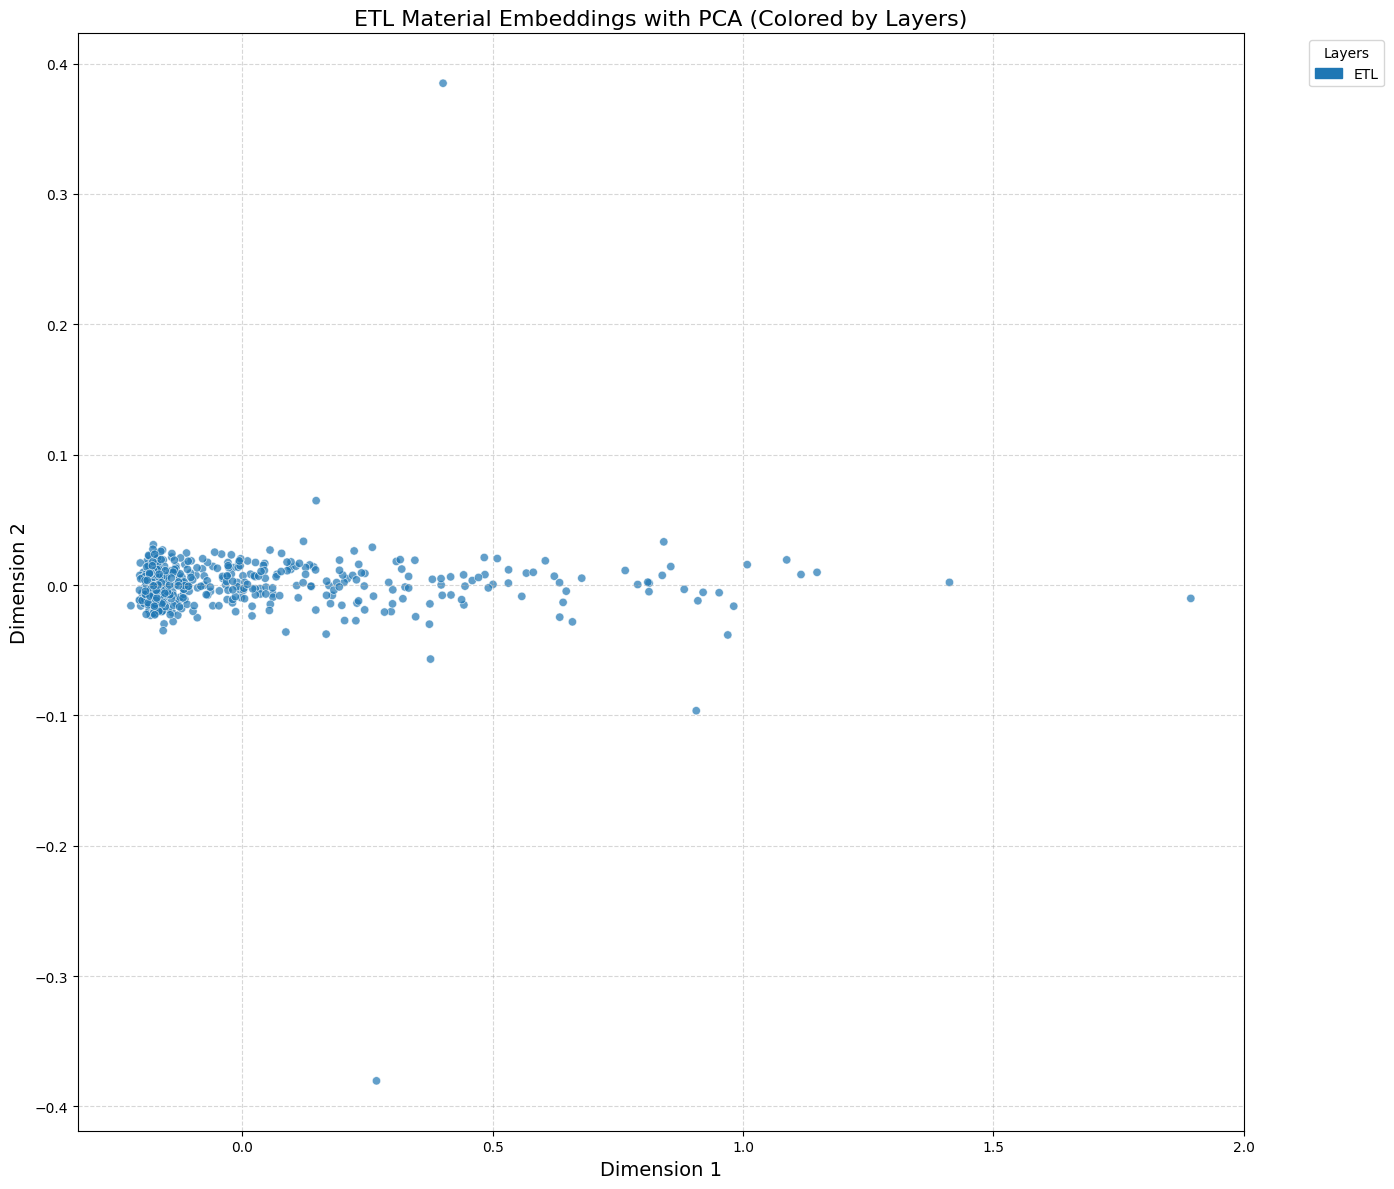

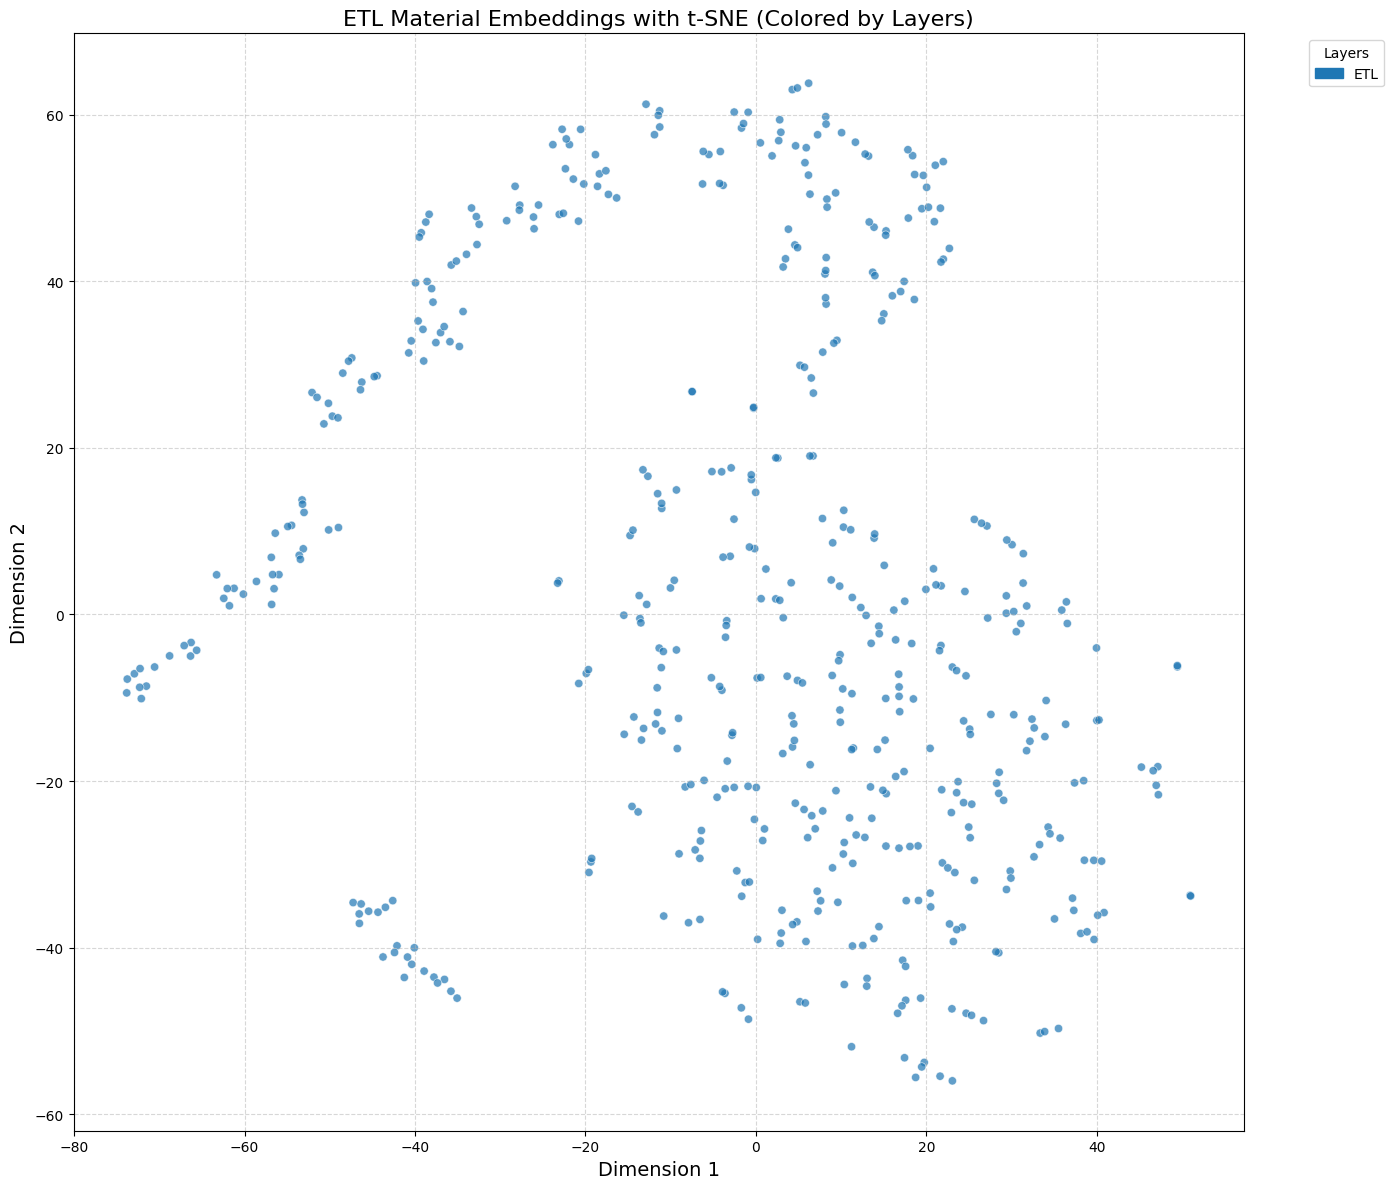

In [2]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches

# 1. Load and Filter Data
def load_and_filter_data(file_path):
    """
    Loads the dataset from the specified CSV file and filters rows where 'Cell_architecture' is 'nip'.
    
    Parameters:
        file_path (str): Path to the CSV file.
    
    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    # Load the dataset
    data = pd.read_csv(file_path)
    
    # Filter rows where 'Cell_architecture' is exactly 'nip' (case-insensitive)
    data = data[data['Cell_architecture'].str.strip().str.lower() == 'nip']
    
    # Reset index after filtering
    data = data.reset_index(drop=True)
    
    return data

# 2. Define Layer Columns
def define_layer_columns():
    """
    Defines the mapping between stack sequence columns and their corresponding layer names.
    
    Returns:
        dict: Dictionary mapping column names to layer names.
    """
    layer_columns = {
        'ETL_stack_sequence': 'ETL',
        # 'HTL_stack_sequence': 'HTL',
        # 'Backcontact_stack_sequence': 'Backcontact',
        # 'Add_lay_back_stack_sequence': 'Add_Lay_Back',
        # 'Encapsulation_stack_sequence': 'Encapsulation',
        # 'Substrate_stack_sequence': 'Substrate'  # Include if relevant
    }
    return layer_columns

# 3. Parse Sequences from Multiple Columns
def parse_sequences_from_columns(dataframe, layer_columns):
    """
    Parses material sequences from multiple layer-specific columns and maps materials to their layers.
    
    Parameters:
        dataframe (pd.DataFrame): The filtered DataFrame.
        layer_columns (dict): Dictionary mapping column names to layer names.
    
    Returns:
        list: Tokenized sequences (list of materials).
        dict: Mapping of materials to layers with occurrence counts.
        list: List of unique layer names.
    """
    sequences = []
    material_layer_map = {}  # Material to layers mapping with counts
    layer_names = list(layer_columns.values())
    
    for idx, row in dataframe.iterrows():
        sequence = []
        for col, layer_name in layer_columns.items():
            seq_str = row.get(col, "")
            if pd.isna(seq_str) or not seq_str.strip():
                continue
            # Split the sequence into sub-layers if applicable
            sub_layers = seq_str.split(' | ')
            for sub_layer in sub_layers:
                # Split sub-layers into materials
                materials = [material.strip() for material in sub_layer.split('; ') if material.strip()]
                sequence.extend(materials)
                for material in materials:
                    if material not in material_layer_map:
                        material_layer_map[material] = {}
                    if layer_name not in material_layer_map[material]:
                        material_layer_map[material][layer_name] = 0
                    material_layer_map[material][layer_name] += 1
        sequences.append(sequence)
    
    return sequences, material_layer_map, layer_names

# 4. Train Word2Vec Model
def train_word2vec(sequences, vector_size=50, window=5, min_count=1, workers=4, sg=1):
    """
    Trains a Word2Vec model on the provided material sequences.
    
    Parameters:
        sequences (list): List of tokenized material sequences.
        vector_size (int): Dimensionality of the embeddings.
        window (int): Context window size.
        min_count (int): Minimum frequency count of materials.
        workers (int): Number of worker threads.
        sg (int): Training algorithm (1 for skip-gram; otherwise CBOW).
    
    Returns:
        Word2Vec: Trained Word2Vec model.
    """
    model = Word2Vec(
        sentences=sequences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        sg=sg
    )
    return model

# 5. Assign Primary Layers to Materials
def assign_primary_layers(material_layer_map):
    """
    Assigns each material to its primary layer based on the highest occurrence.
    
    Parameters:
        material_layer_map (dict): Mapping of materials to layers with occurrence counts.
    
    Returns:
        dict: Mapping of materials to their primary layer.
    """
    material_primary_layer = {}
    for material, layers in material_layer_map.items():
        # Assign the material to the layer where it occurs most frequently
        primary_layer = max(layers, key=layers.get)
        material_primary_layer[material] = primary_layer
    return material_primary_layer

# 6. Assign Colors to Layers
def assign_colors_to_layers(layer_names):
    """
    Assigns distinct colors to each layer using a colormap.
    
    Parameters:
        layer_names (list): List of unique layer names.
    
    Returns:
        dict: Mapping of layer names to colors.
    """
    num_layers = len(layer_names)
    cmap = cm.get_cmap('tab10', num_layers) if num_layers <= 10 else cm.get_cmap('tab20', num_layers)
    
    layer_colors = {}
    for idx, layer_name in enumerate(layer_names):
        layer_colors[layer_name] = cmap(idx)
    return layer_colors

# 7. Extract Embeddings
def extract_embeddings(model, materials):
    """
    Extracts embeddings for each material from the Word2Vec model.
    
    Parameters:
        model (Word2Vec): Trained Word2Vec model.
        materials (list): List of materials.
    
    Returns:
        np.ndarray: Array of embeddings.
    """
    embeddings = np.array([model.wv[material] for material in materials])
    return embeddings

# 8. Plot Embeddings with Color Coding
def plot_embeddings_colored(embeddings_2d, materials, material_primary_layer, layer_colors, title, annotate=True):
    """
    Plots the 2D embeddings with colors based on their primary layers.
    
    Parameters:
        embeddings_2d (np.ndarray): 2D embeddings.
        materials (list): List of materials.
        material_primary_layer (dict): Mapping of materials to their primary layers.
        layer_colors (dict): Mapping of layer names to colors.
        title (str): Title of the plot.
        annotate (bool): Whether to annotate material names on the plot.
    """
    plt.figure(figsize=(14, 12))
    
    # Assign colors to each material based on its primary layer
    colors_list = [layer_colors[material_primary_layer[material]] for material in materials]
    
    # Create scatter plot
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors_list, alpha=0.7, edgecolors='w', linewidth=0.5)
    
    # Optionally annotate materials
    if annotate:
        for i, material in enumerate(materials):
            plt.annotate(material, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.75)
    
    # Create legend
    legend_handles = []
    for layer_name, color in layer_colors.items():
        patch = mpatches.Patch(color=color, label=layer_name)
        legend_handles.append(patch)
    plt.legend(handles=legend_handles, title='Layers', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 9. Main Execution Function
def main():
    # File path to the CSV dataset
    file_path = 'perovskite_database_query.csv'
    
    # Load and filter data
    data = load_and_filter_data(file_path)
    
    # Define layer columns and their corresponding layer names
    layer_columns = define_layer_columns()
    
    # Parse sequences from the specified columns
    tokenized_sequences, material_layer_map, layer_names = parse_sequences_from_columns(data, layer_columns)
    
    # Train Word2Vec model
    model = train_word2vec(tokenized_sequences)
    
    # Get list of unique materials
    materials = list(model.wv.index_to_key)
    print(f"Number of unique materials in ETL_stack_sequence: {len(materials)}")
    
    # Assign primary layers to materials
    material_primary_layer = assign_primary_layers(material_layer_map)
    
    # Assign colors to layers
    layer_colors = assign_colors_to_layers(layer_names)
    
    # Extract embeddings
    embeddings = extract_embeddings(model, materials)
    
    # Reduce dimensions using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_embeddings_pca = pca.fit_transform(embeddings)
    
    # Plot embeddings using PCA with color coding
    plot_embeddings_colored(
        embeddings_2d=reduced_embeddings_pca,
        materials=materials,
        material_primary_layer=material_primary_layer,
        layer_colors=layer_colors,
        title='ETL Material Embeddings with PCA (Colored by Layers)',
        annotate=False  # Set to True to display annotations
    )
    
    # Reduce dimensions using t-SNE
    tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='random', learning_rate='auto')
    reduced_embeddings_tsne = tsne.fit_transform(embeddings)
    
    # Plot embeddings using t-SNE with color coding
    plot_embeddings_colored(
        embeddings_2d=reduced_embeddings_tsne,
        materials=materials,
        material_primary_layer=material_primary_layer,
        layer_colors=layer_colors,
        title='ETL Material Embeddings with t-SNE (Colored by Layers)',
        annotate=False  # Set to True to display annotations
    )

if __name__ == "__main__":
    main()


/var/folders/j3/pj3kpjws5gj32d8zrny204340000gn/T/ipykernel_30867/107477061.py:23: DtypeWarning: Columns (10,22,29,31,32,35,36,40,44,45,46,48,51,54,65,84,89,90,93,98,99,100,105,108,115,118,122,123,125,130,134,138,142,143,144,146,149,152,163,166,167,171,172,173,175,178,181,192,194,225,271,272,273,277,304,315,321,325,330,331,335,336,342,348,369,371,373,374,376,380,384,387,403,405,407,409) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Number of unique materials in ETL_stack_sequence: 1316


/var/folders/j3/pj3kpjws5gj32d8zrny204340000gn/T/ipykernel_30867/107477061.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', num_layers) if num_layers <= 10 else cm.get_cmap('tab20', num_layers)


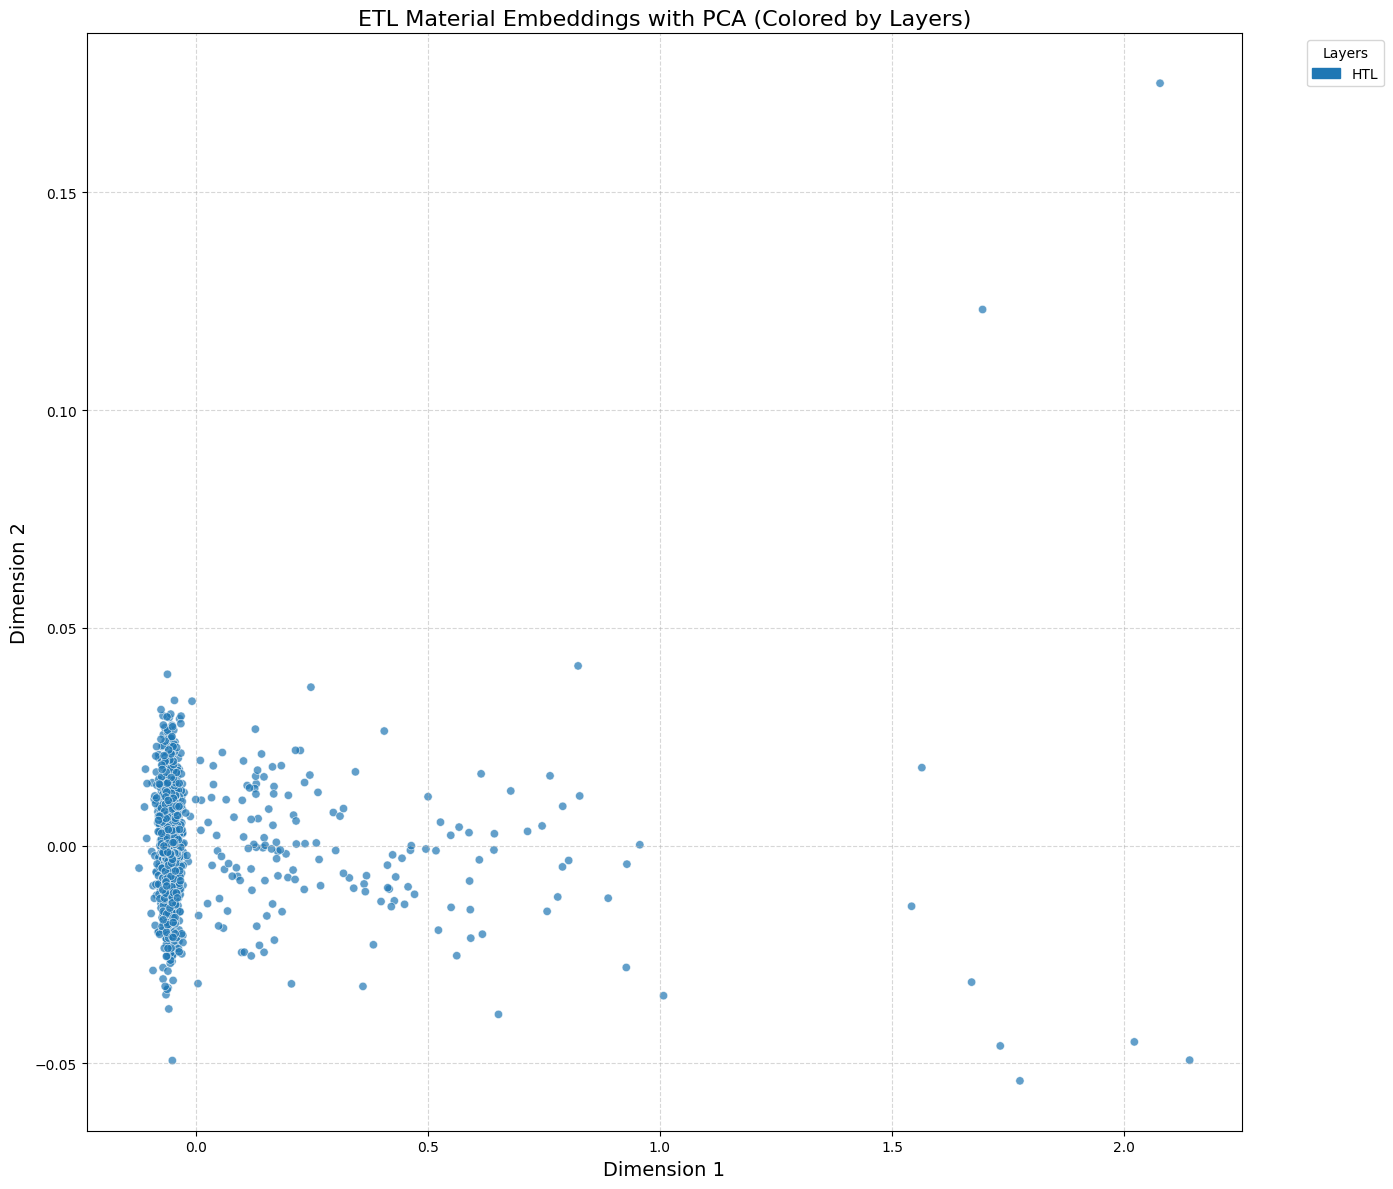

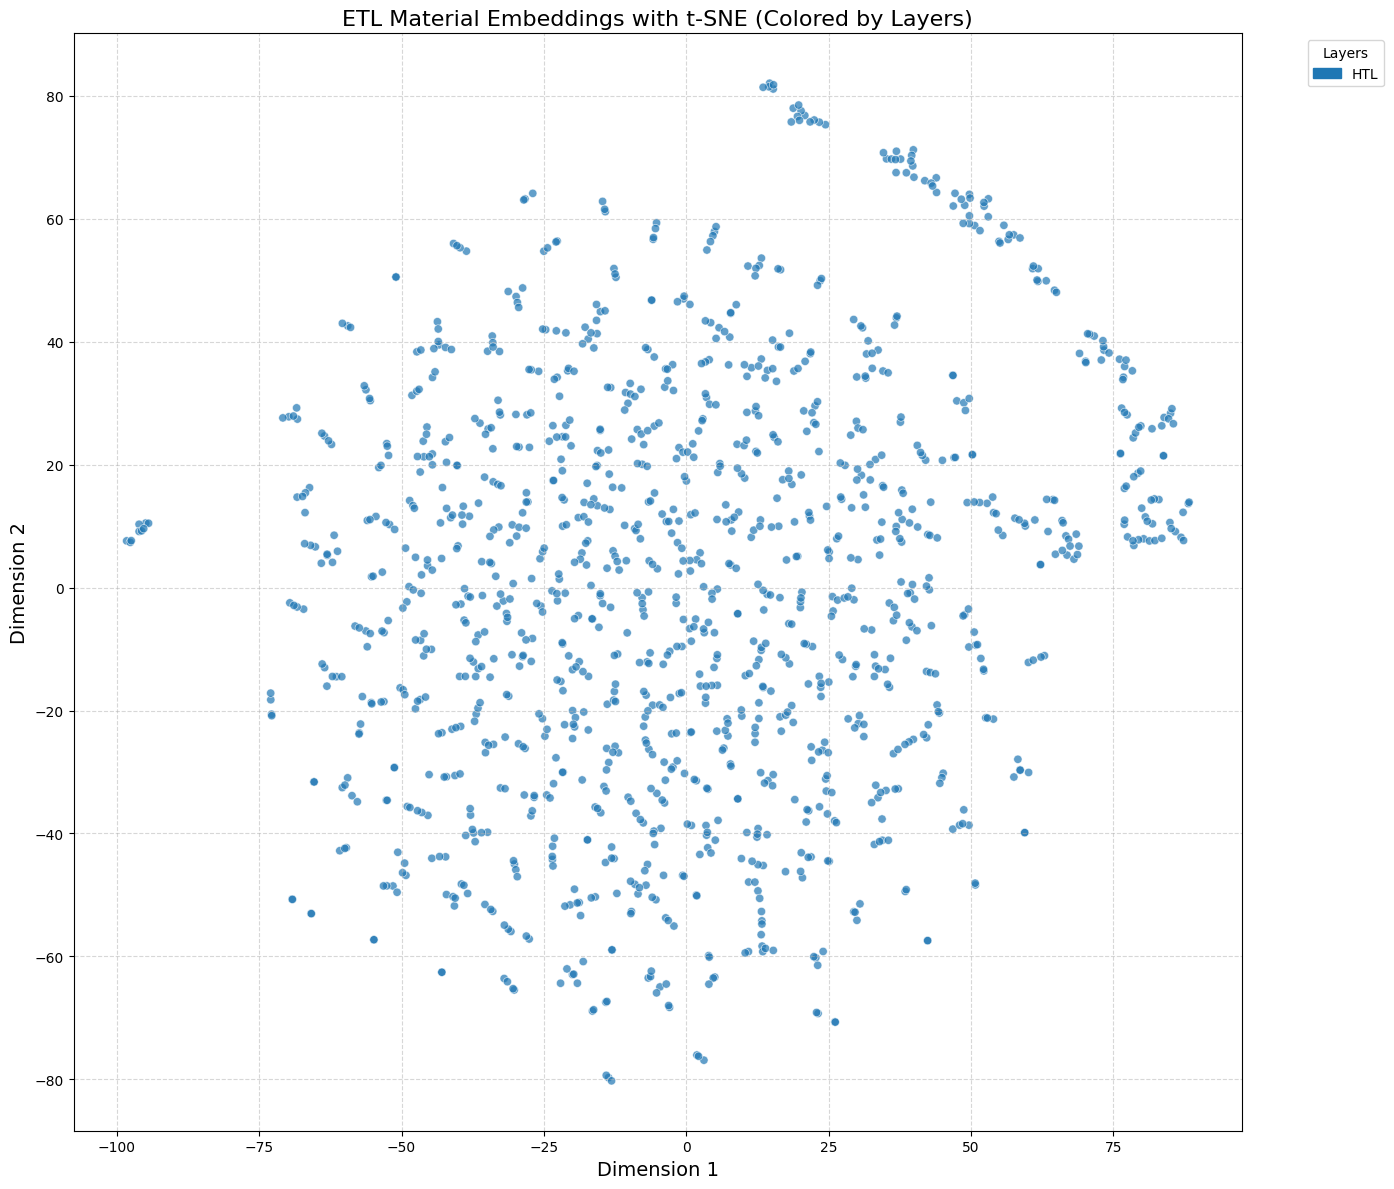

In [3]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches

# 1. Load and Filter Data
def load_and_filter_data(file_path):
    """
    Loads the dataset from the specified CSV file and filters rows where 'Cell_architecture' is 'nip'.
    
    Parameters:
        file_path (str): Path to the CSV file.
    
    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    # Load the dataset
    data = pd.read_csv(file_path)
    
    # Filter rows where 'Cell_architecture' is exactly 'nip' (case-insensitive)
    data = data[data['Cell_architecture'].str.strip().str.lower() == 'nip']
    
    # Reset index after filtering
    data = data.reset_index(drop=True)
    
    return data

# 2. Define Layer Columns
def define_layer_columns():
    """
    Defines the mapping between stack sequence columns and their corresponding layer names.
    
    Returns:
        dict: Dictionary mapping column names to layer names.
    """
    layer_columns = {
        # 'ETL_stack_sequence': 'ETL',
        'HTL_stack_sequence': 'HTL',
        # 'Backcontact_stack_sequence': 'Backcontact',
        # 'Add_lay_back_stack_sequence': 'Add_Lay_Back',
        # 'Encapsulation_stack_sequence': 'Encapsulation',
        # 'Substrate_stack_sequence': 'Substrate'  # Include if relevant
    }
    return layer_columns

# 3. Parse Sequences from Multiple Columns
def parse_sequences_from_columns(dataframe, layer_columns):
    """
    Parses material sequences from multiple layer-specific columns and maps materials to their layers.
    
    Parameters:
        dataframe (pd.DataFrame): The filtered DataFrame.
        layer_columns (dict): Dictionary mapping column names to layer names.
    
    Returns:
        list: Tokenized sequences (list of materials).
        dict: Mapping of materials to layers with occurrence counts.
        list: List of unique layer names.
    """
    sequences = []
    material_layer_map = {}  # Material to layers mapping with counts
    layer_names = list(layer_columns.values())
    
    for idx, row in dataframe.iterrows():
        sequence = []
        for col, layer_name in layer_columns.items():
            seq_str = row.get(col, "")
            if pd.isna(seq_str) or not seq_str.strip():
                continue
            # Split the sequence into sub-layers if applicable
            sub_layers = seq_str.split(' | ')
            for sub_layer in sub_layers:
                # Split sub-layers into materials
                materials = [material.strip() for material in sub_layer.split('; ') if material.strip()]
                sequence.extend(materials)
                for material in materials:
                    if material not in material_layer_map:
                        material_layer_map[material] = {}
                    if layer_name not in material_layer_map[material]:
                        material_layer_map[material][layer_name] = 0
                    material_layer_map[material][layer_name] += 1
        sequences.append(sequence)
    
    return sequences, material_layer_map, layer_names

# 4. Train Word2Vec Model
def train_word2vec(sequences, vector_size=50, window=5, min_count=1, workers=4, sg=1):
    """
    Trains a Word2Vec model on the provided material sequences.
    
    Parameters:
        sequences (list): List of tokenized material sequences.
        vector_size (int): Dimensionality of the embeddings.
        window (int): Context window size.
        min_count (int): Minimum frequency count of materials.
        workers (int): Number of worker threads.
        sg (int): Training algorithm (1 for skip-gram; otherwise CBOW).
    
    Returns:
        Word2Vec: Trained Word2Vec model.
    """
    model = Word2Vec(
        sentences=sequences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        sg=sg
    )
    return model

# 5. Assign Primary Layers to Materials
def assign_primary_layers(material_layer_map):
    """
    Assigns each material to its primary layer based on the highest occurrence.
    
    Parameters:
        material_layer_map (dict): Mapping of materials to layers with occurrence counts.
    
    Returns:
        dict: Mapping of materials to their primary layer.
    """
    material_primary_layer = {}
    for material, layers in material_layer_map.items():
        # Assign the material to the layer where it occurs most frequently
        primary_layer = max(layers, key=layers.get)
        material_primary_layer[material] = primary_layer
    return material_primary_layer

# 6. Assign Colors to Layers
def assign_colors_to_layers(layer_names):
    """
    Assigns distinct colors to each layer using a colormap.
    
    Parameters:
        layer_names (list): List of unique layer names.
    
    Returns:
        dict: Mapping of layer names to colors.
    """
    num_layers = len(layer_names)
    cmap = cm.get_cmap('tab10', num_layers) if num_layers <= 10 else cm.get_cmap('tab20', num_layers)
    
    layer_colors = {}
    for idx, layer_name in enumerate(layer_names):
        layer_colors[layer_name] = cmap(idx)
    return layer_colors

# 7. Extract Embeddings
def extract_embeddings(model, materials):
    """
    Extracts embeddings for each material from the Word2Vec model.
    
    Parameters:
        model (Word2Vec): Trained Word2Vec model.
        materials (list): List of materials.
    
    Returns:
        np.ndarray: Array of embeddings.
    """
    embeddings = np.array([model.wv[material] for material in materials])
    return embeddings

# 8. Plot Embeddings with Color Coding
def plot_embeddings_colored(embeddings_2d, materials, material_primary_layer, layer_colors, title, annotate=True):
    """
    Plots the 2D embeddings with colors based on their primary layers.
    
    Parameters:
        embeddings_2d (np.ndarray): 2D embeddings.
        materials (list): List of materials.
        material_primary_layer (dict): Mapping of materials to their primary layers.
        layer_colors (dict): Mapping of layer names to colors.
        title (str): Title of the plot.
        annotate (bool): Whether to annotate material names on the plot.
    """
    plt.figure(figsize=(14, 12))
    
    # Assign colors to each material based on its primary layer
    colors_list = [layer_colors[material_primary_layer[material]] for material in materials]
    
    # Create scatter plot
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors_list, alpha=0.7, edgecolors='w', linewidth=0.5)
    
    # Optionally annotate materials
    if annotate:
        for i, material in enumerate(materials):
            plt.annotate(material, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.75)
    
    # Create legend
    legend_handles = []
    for layer_name, color in layer_colors.items():
        patch = mpatches.Patch(color=color, label=layer_name)
        legend_handles.append(patch)
    plt.legend(handles=legend_handles, title='Layers', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 9. Main Execution Function
def main():
    # File path to the CSV dataset
    file_path = 'perovskite_database_query.csv'
    
    # Load and filter data
    data = load_and_filter_data(file_path)
    
    # Define layer columns and their corresponding layer names
    layer_columns = define_layer_columns()
    
    # Parse sequences from the specified columns
    tokenized_sequences, material_layer_map, layer_names = parse_sequences_from_columns(data, layer_columns)
    
    # Train Word2Vec model
    model = train_word2vec(tokenized_sequences)
    
    # Get list of unique materials
    materials = list(model.wv.index_to_key)
    print(f"Number of unique materials in ETL_stack_sequence: {len(materials)}")
    
    # Assign primary layers to materials
    material_primary_layer = assign_primary_layers(material_layer_map)
    
    # Assign colors to layers
    layer_colors = assign_colors_to_layers(layer_names)
    
    # Extract embeddings
    embeddings = extract_embeddings(model, materials)
    
    # Reduce dimensions using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_embeddings_pca = pca.fit_transform(embeddings)
    
    # Plot embeddings using PCA with color coding
    plot_embeddings_colored(
        embeddings_2d=reduced_embeddings_pca,
        materials=materials,
        material_primary_layer=material_primary_layer,
        layer_colors=layer_colors,
        title='ETL Material Embeddings with PCA (Colored by Layers)',
        annotate=False  # Set to True to display annotations
    )
    
    # Reduce dimensions using t-SNE
    tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='random', learning_rate='auto')
    reduced_embeddings_tsne = tsne.fit_transform(embeddings)
    
    # Plot embeddings using t-SNE with color coding
    plot_embeddings_colored(
        embeddings_2d=reduced_embeddings_tsne,
        materials=materials,
        material_primary_layer=material_primary_layer,
        layer_colors=layer_colors,
        title='ETL Material Embeddings with t-SNE (Colored by Layers)',
        annotate=False  # Set to True to display annotations
    )

if __name__ == "__main__":
    main()


/var/folders/j3/pj3kpjws5gj32d8zrny204340000gn/T/ipykernel_30867/3034245228.py:23: DtypeWarning: Columns (10,22,29,31,32,35,36,40,44,45,46,48,51,54,65,84,89,90,93,98,99,100,105,108,115,118,122,123,125,130,134,138,142,143,144,146,149,152,163,166,167,171,172,173,175,178,181,192,194,225,271,272,273,277,304,315,321,325,330,331,335,336,342,348,369,371,373,374,376,380,384,387,403,405,407,409) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Number of unique materials in ETL_stack_sequence: 82


/var/folders/j3/pj3kpjws5gj32d8zrny204340000gn/T/ipykernel_30867/3034245228.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', num_layers) if num_layers <= 10 else cm.get_cmap('tab20', num_layers)


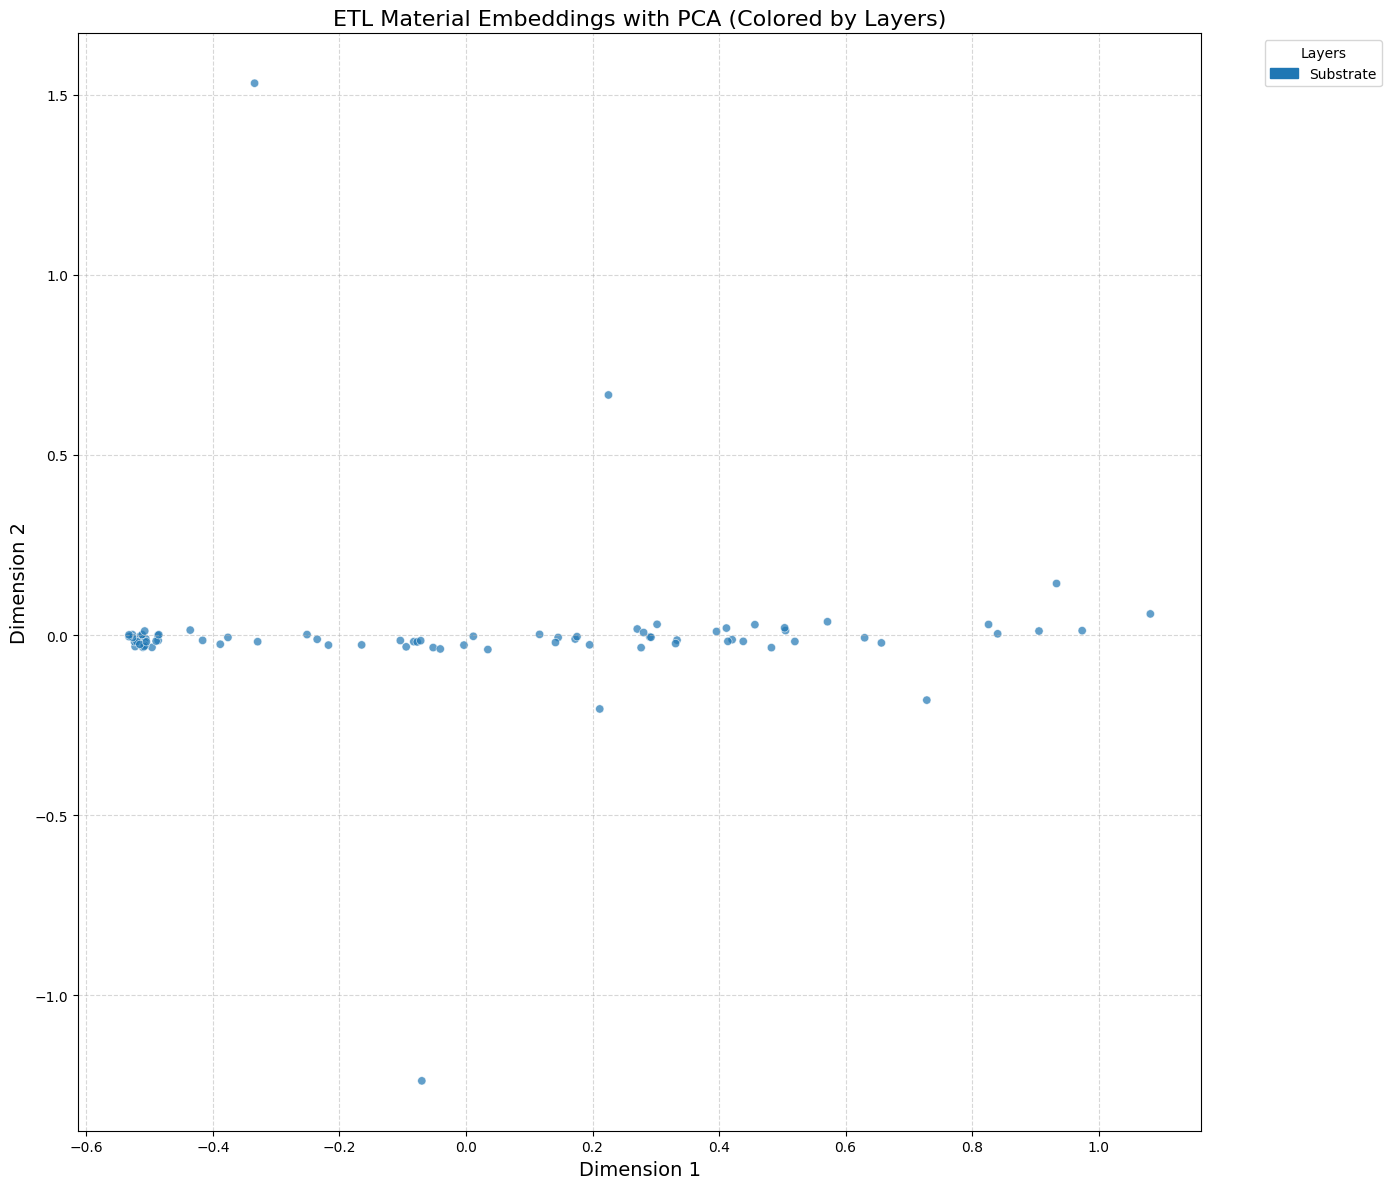

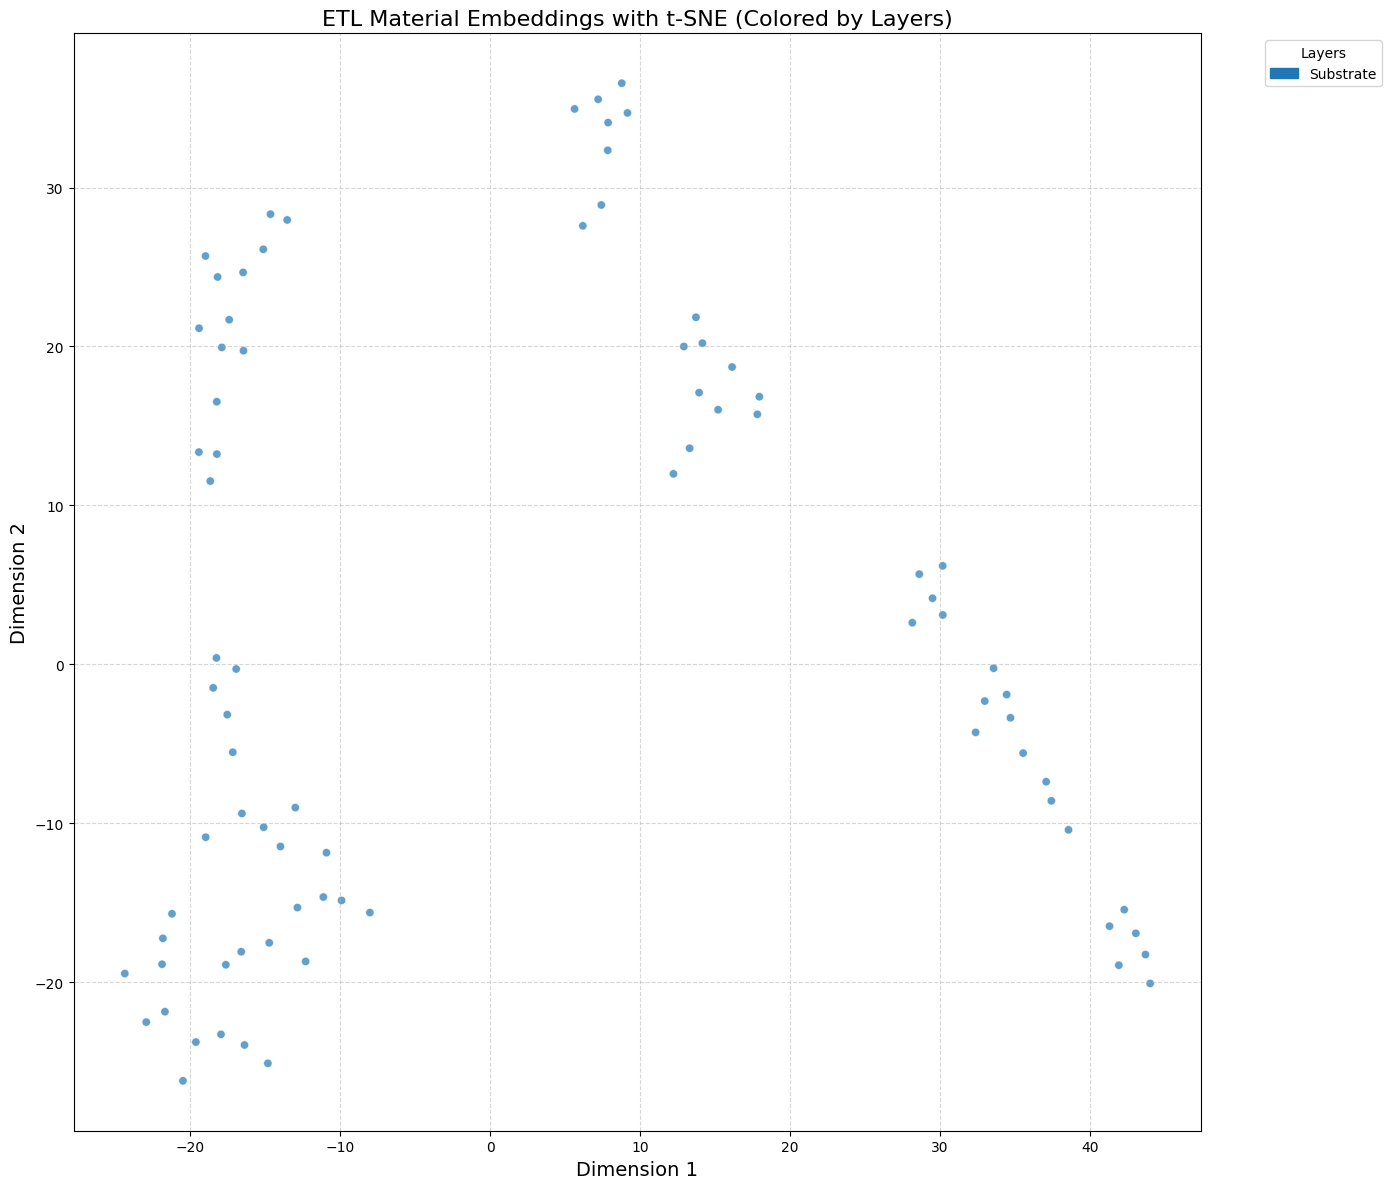

In [13]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches

# 1. Load and Filter Data
def load_and_filter_data(file_path):
    """
    Loads the dataset from the specified CSV file and filters rows where 'Cell_architecture' is 'nip'.
    
    Parameters:
        file_path (str): Path to the CSV file.
    
    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    # Load the dataset
    data = pd.read_csv(file_path)
    
    # Filter rows where 'Cell_architecture' is exactly 'nip' (case-insensitive)
    data = data[data['Cell_architecture'].str.strip().str.lower() == 'nip']
    
    # Reset index after filtering
    data = data.reset_index(drop=True)
    
    return data

# 2. Define Layer Columns
def define_layer_columns():
    """
    Defines the mapping between stack sequence columns and their corresponding layer names.
    
    Returns:
        dict: Dictionary mapping column names to layer names.
    """
    layer_columns = {
        # 'ETL_stack_sequence': 'ETL',
        # 'HTL_stack_sequence': 'HTL',
        # 'Backcontact_stack_sequence': 'Backcontact',
        # 'Add_lay_back_stack_sequence': 'Add_Lay_Back',
        # 'Encapsulation_stack_sequence': 'Encapsulation',
        'Substrate_stack_sequence': 'Substrate'  # Include if relevant
    }
    return layer_columns

# 3. Parse Sequences from Multiple Columns
def parse_sequences_from_columns(dataframe, layer_columns):
    """
    Parses material sequences from multiple layer-specific columns and maps materials to their layers.
    
    Parameters:
        dataframe (pd.DataFrame): The filtered DataFrame.
        layer_columns (dict): Dictionary mapping column names to layer names.
    
    Returns:
        list: Tokenized sequences (list of materials).
        dict: Mapping of materials to layers with occurrence counts.
        list: List of unique layer names.
    """
    sequences = []
    material_layer_map = {}  # Material to layers mapping with counts
    layer_names = list(layer_columns.values())
    
    for idx, row in dataframe.iterrows():
        sequence = []
        for col, layer_name in layer_columns.items():
            seq_str = row.get(col, "")
            if pd.isna(seq_str) or not seq_str.strip():
                continue
            # Split the sequence into sub-layers if applicable
            sub_layers = seq_str.split(' | ')
            for sub_layer in sub_layers:
                # Split sub-layers into materials
                materials = [material.strip() for material in sub_layer.split('; ') if material.strip()]
                sequence.extend(materials)
                for material in materials:
                    if material not in material_layer_map:
                        material_layer_map[material] = {}
                    if layer_name not in material_layer_map[material]:
                        material_layer_map[material][layer_name] = 0
                    material_layer_map[material][layer_name] += 1
        sequences.append(sequence)
    
    return sequences, material_layer_map, layer_names

# 4. Train Word2Vec Model
def train_word2vec(sequences, vector_size=50, window=5, min_count=1, workers=4, sg=1):
    """
    Trains a Word2Vec model on the provided material sequences.
    
    Parameters:
        sequences (list): List of tokenized material sequences.
        vector_size (int): Dimensionality of the embeddings.
        window (int): Context window size.
        min_count (int): Minimum frequency count of materials.
        workers (int): Number of worker threads.
        sg (int): Training algorithm (1 for skip-gram; otherwise CBOW).
    
    Returns:
        Word2Vec: Trained Word2Vec model.
    """
    model = Word2Vec(
        sentences=sequences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        sg=sg
    )
    return model

# 5. Assign Primary Layers to Materials
def assign_primary_layers(material_layer_map):
    """
    Assigns each material to its primary layer based on the highest occurrence.
    
    Parameters:
        material_layer_map (dict): Mapping of materials to layers with occurrence counts.
    
    Returns:
        dict: Mapping of materials to their primary layer.
    """
    material_primary_layer = {}
    for material, layers in material_layer_map.items():
        # Assign the material to the layer where it occurs most frequently
        primary_layer = max(layers, key=layers.get)
        material_primary_layer[material] = primary_layer
    return material_primary_layer

# 6. Assign Colors to Layers
def assign_colors_to_layers(layer_names):
    """
    Assigns distinct colors to each layer using a colormap.
    
    Parameters:
        layer_names (list): List of unique layer names.
    
    Returns:
        dict: Mapping of layer names to colors.
    """
    num_layers = len(layer_names)
    cmap = cm.get_cmap('tab10', num_layers) if num_layers <= 10 else cm.get_cmap('tab20', num_layers)
    
    layer_colors = {}
    for idx, layer_name in enumerate(layer_names):
        layer_colors[layer_name] = cmap(idx)
    return layer_colors

# 7. Extract Embeddings
def extract_embeddings(model, materials):
    """
    Extracts embeddings for each material from the Word2Vec model.
    
    Parameters:
        model (Word2Vec): Trained Word2Vec model.
        materials (list): List of materials.
    
    Returns:
        np.ndarray: Array of embeddings.
    """
    embeddings = np.array([model.wv[material] for material in materials])
    return embeddings

# 8. Plot Embeddings with Color Coding
def plot_embeddings_colored(embeddings_2d, materials, material_primary_layer, layer_colors, title, annotate=True):
    """
    Plots the 2D embeddings with colors based on their primary layers.
    
    Parameters:
        embeddings_2d (np.ndarray): 2D embeddings.
        materials (list): List of materials.
        material_primary_layer (dict): Mapping of materials to their primary layers.
        layer_colors (dict): Mapping of layer names to colors.
        title (str): Title of the plot.
        annotate (bool): Whether to annotate material names on the plot.
    """
    plt.figure(figsize=(14, 12))
    
    # Assign colors to each material based on its primary layer
    colors_list = [layer_colors[material_primary_layer[material]] for material in materials]
    
    # Create scatter plot
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors_list, alpha=0.7, edgecolors='w', linewidth=0.5)
    
    # Optionally annotate materials
    if annotate:
        for i, material in enumerate(materials):
            plt.annotate(material, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.75)
    
    # Create legend
    legend_handles = []
    for layer_name, color in layer_colors.items():
        patch = mpatches.Patch(color=color, label=layer_name)
        legend_handles.append(patch)
    plt.legend(handles=legend_handles, title='Layers', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 9. Main Execution Function
def main():
    # File path to the CSV dataset
    file_path = 'perovskite_database_query.csv'
    
    # Load and filter data
    data = load_and_filter_data(file_path)
    
    # Define layer columns and their corresponding layer names
    layer_columns = define_layer_columns()
    
    # Parse sequences from the specified columns
    tokenized_sequences, material_layer_map, layer_names = parse_sequences_from_columns(data, layer_columns)
    
    # Train Word2Vec model
    model = train_word2vec(tokenized_sequences)
    
    # Get list of unique materials
    materials = list(model.wv.index_to_key)
    print(f"Number of unique materials in ETL_stack_sequence: {len(materials)}")
    
    # Assign primary layers to materials
    material_primary_layer = assign_primary_layers(material_layer_map)
    
    # Assign colors to layers
    layer_colors = assign_colors_to_layers(layer_names)
    
    # Extract embeddings
    embeddings = extract_embeddings(model, materials)
    
    # Reduce dimensions using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_embeddings_pca = pca.fit_transform(embeddings)
    
    # Plot embeddings using PCA with color coding
    plot_embeddings_colored(
        embeddings_2d=reduced_embeddings_pca,
        materials=materials,
        material_primary_layer=material_primary_layer,
        layer_colors=layer_colors,
        title='ETL Material Embeddings with PCA (Colored by Layers)',
        annotate=False  # Set to True to display annotations
    )
    
    # Reduce dimensions using t-SNE
    tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='random', learning_rate='auto')
    reduced_embeddings_tsne = tsne.fit_transform(embeddings)
    
    # Plot embeddings using t-SNE with color coding
    plot_embeddings_colored(
        embeddings_2d=reduced_embeddings_tsne,
        materials=materials,
        material_primary_layer=material_primary_layer,
        layer_colors=layer_colors,
        title='ETL Material Embeddings with t-SNE (Colored by Layers)',
        annotate=False  # Set to True to display annotations
    )

if __name__ == "__main__":
    main()


/var/folders/j3/pj3kpjws5gj32d8zrny204340000gn/T/ipykernel_30867/324463524.py:23: DtypeWarning: Columns (10,22,29,31,32,35,36,40,44,45,46,48,51,54,65,84,89,90,93,98,99,100,105,108,115,118,122,123,125,130,134,138,142,143,144,146,149,152,163,166,167,171,172,173,175,178,181,192,194,225,271,272,273,277,304,315,321,325,330,331,335,336,342,348,369,371,373,374,376,380,384,387,403,405,407,409) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Number of unique materials in ETL_stack_sequence: 82


/var/folders/j3/pj3kpjws5gj32d8zrny204340000gn/T/ipykernel_30867/324463524.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', num_layers) if num_layers <= 10 else cm.get_cmap('tab20', num_layers)


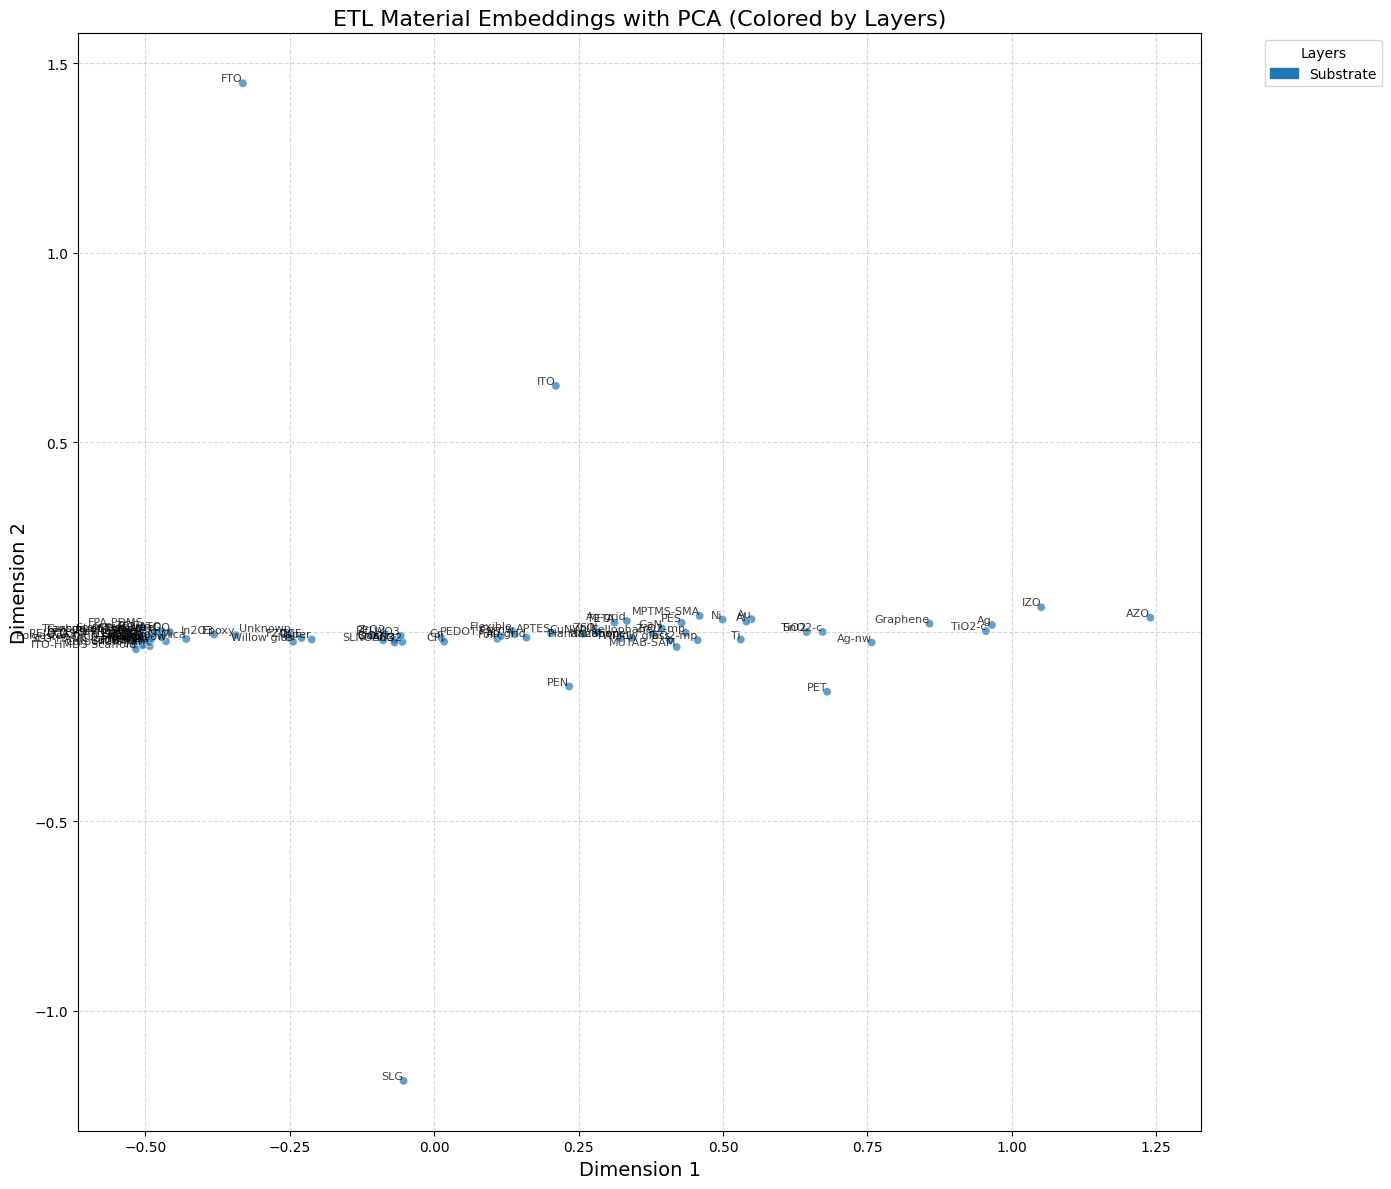

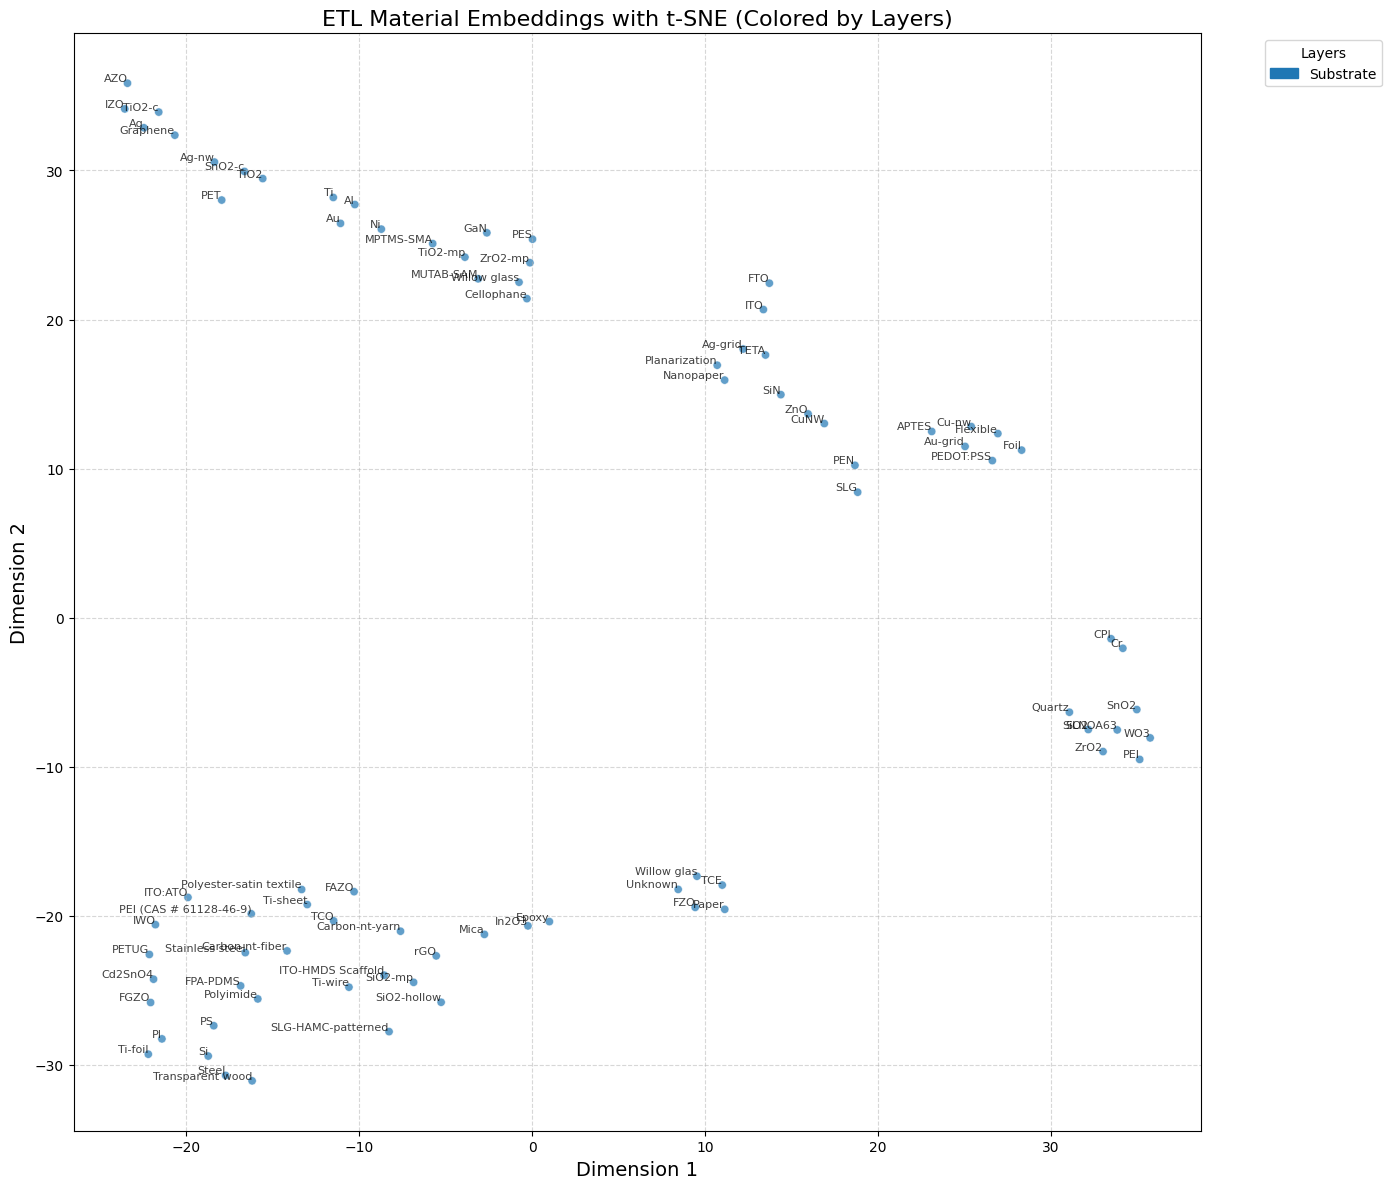

In [16]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches

# 1. Load and Filter Data
def load_and_filter_data(file_path):
    """
    Loads the dataset from the specified CSV file and filters rows where 'Cell_architecture' is 'nip'.
    
    Parameters:
        file_path (str): Path to the CSV file.
    
    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    # Load the dataset
    data = pd.read_csv(file_path)
    
    # Filter rows where 'Cell_architecture' is exactly 'nip' (case-insensitive)
    data = data[data['Cell_architecture'].str.strip().str.lower() == 'nip']
    
    # Reset index after filtering
    data = data.reset_index(drop=True)
    
    return data

# 2. Define Layer Columns
def define_layer_columns():
    """
    Defines the mapping between stack sequence columns and their corresponding layer names.
    
    Returns:
        dict: Dictionary mapping column names to layer names.
    """
    layer_columns = {
        # 'ETL_stack_sequence': 'ETL',
        # 'HTL_stack_sequence': 'HTL',
        # 'Backcontact_stack_sequence': 'Backcontact',
        # 'Add_lay_back_stack_sequence': 'Add_Lay_Back',
        # 'Encapsulation_stack_sequence': 'Encapsulation',
        'Substrate_stack_sequence': 'Substrate'  # Include if relevant
    }
    return layer_columns

# 3. Parse Sequences from Multiple Columns
def parse_sequences_from_columns(dataframe, layer_columns):
    """
    Parses material sequences from multiple layer-specific columns and maps materials to their layers.
    
    Parameters:
        dataframe (pd.DataFrame): The filtered DataFrame.
        layer_columns (dict): Dictionary mapping column names to layer names.
    
    Returns:
        list: Tokenized sequences (list of materials).
        dict: Mapping of materials to layers with occurrence counts.
        list: List of unique layer names.
    """
    sequences = []
    material_layer_map = {}  # Material to layers mapping with counts
    layer_names = list(layer_columns.values())
    
    for idx, row in dataframe.iterrows():
        sequence = []
        for col, layer_name in layer_columns.items():
            seq_str = row.get(col, "")
            if pd.isna(seq_str) or not seq_str.strip():
                continue
            # Split the sequence into sub-layers if applicable
            sub_layers = seq_str.split(' | ')
            for sub_layer in sub_layers:
                # Split sub-layers into materials
                materials = [material.strip() for material in sub_layer.split('; ') if material.strip()]
                sequence.extend(materials)
                for material in materials:
                    if material not in material_layer_map:
                        material_layer_map[material] = {}
                    if layer_name not in material_layer_map[material]:
                        material_layer_map[material][layer_name] = 0
                    material_layer_map[material][layer_name] += 1
        sequences.append(sequence)
    
    return sequences, material_layer_map, layer_names

# 4. Train Word2Vec Model
def train_word2vec(sequences, vector_size=50, window=5, min_count=1, workers=4, sg=1):
    """
    Trains a Word2Vec model on the provided material sequences.
    
    Parameters:
        sequences (list): List of tokenized material sequences.
        vector_size (int): Dimensionality of the embeddings.
        window (int): Context window size.
        min_count (int): Minimum frequency count of materials.
        workers (int): Number of worker threads.
        sg (int): Training algorithm (1 for skip-gram; otherwise CBOW).
    
    Returns:
        Word2Vec: Trained Word2Vec model.
    """
    model = Word2Vec(
        sentences=sequences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        sg=sg
    )
    return model

# 5. Assign Primary Layers to Materials
def assign_primary_layers(material_layer_map):
    """
    Assigns each material to its primary layer based on the highest occurrence.
    
    Parameters:
        material_layer_map (dict): Mapping of materials to layers with occurrence counts.
    
    Returns:
        dict: Mapping of materials to their primary layer.
    """
    material_primary_layer = {}
    for material, layers in material_layer_map.items():
        # Assign the material to the layer where it occurs most frequently
        primary_layer = max(layers, key=layers.get)
        material_primary_layer[material] = primary_layer
    return material_primary_layer

# 6. Assign Colors to Layers
def assign_colors_to_layers(layer_names):
    """
    Assigns distinct colors to each layer using a colormap.
    
    Parameters:
        layer_names (list): List of unique layer names.
    
    Returns:
        dict: Mapping of layer names to colors.
    """
    num_layers = len(layer_names)
    cmap = cm.get_cmap('tab10', num_layers) if num_layers <= 10 else cm.get_cmap('tab20', num_layers)
    
    layer_colors = {}
    for idx, layer_name in enumerate(layer_names):
        layer_colors[layer_name] = cmap(idx)
    return layer_colors

# 7. Extract Embeddings
def extract_embeddings(model, materials):
    """
    Extracts embeddings for each material from the Word2Vec model.
    
    Parameters:
        model (Word2Vec): Trained Word2Vec model.
        materials (list): List of materials.
    
    Returns:
        np.ndarray: Array of embeddings.
    """
    embeddings = np.array([model.wv[material] for material in materials])
    return embeddings

# 8. Plot Embeddings with Color Coding and Labels
def plot_embeddings_colored(embeddings_2d, materials, material_primary_layer, layer_colors, title, annotate=True):
    """
    Plots the 2D embeddings with colors based on their primary layers and labels each vector.
    
    Parameters:
        embeddings_2d (np.ndarray): 2D embeddings.
        materials (list): List of materials.
        material_primary_layer (dict): Mapping of materials to their primary layers.
        layer_colors (dict): Mapping of layer names to colors.
        title (str): Title of the plot.
        annotate (bool): Whether to annotate material names on the plot.
    """
    plt.figure(figsize=(14, 12))
    
    # Assign colors to each material based on its primary layer
    colors_list = [layer_colors[material_primary_layer[material]] for material in materials]
    
    # Create scatter plot
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors_list, alpha=0.7, edgecolors='w', linewidth=0.5)
    
    # Optionally annotate materials
    if annotate:
        for i, material in enumerate(materials):
            plt.annotate(material, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]),
                         fontsize=8, alpha=0.75, ha='right', va='bottom')
    
    # Create legend
    legend_handles = []
    for layer_name, color in layer_colors.items():
        patch = mpatches.Patch(color=color, label=layer_name)
        legend_handles.append(patch)
    plt.legend(handles=legend_handles, title='Layers', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 9. Main Execution Function
def main():
    # File path to the CSV dataset
    file_path = 'perovskite_database_query.csv'
    
    # Load and filter data
    data = load_and_filter_data(file_path)
    
    # Define layer columns and their corresponding layer names
    layer_columns = define_layer_columns()
    
    # Parse sequences from the specified columns
    tokenized_sequences, material_layer_map, layer_names = parse_sequences_from_columns(data, layer_columns)
    
    # Train Word2Vec model
    model = train_word2vec(tokenized_sequences)
    
    # Get list of unique materials
    materials = list(model.wv.index_to_key)
    print(f"Number of unique materials in ETL_stack_sequence: {len(materials)}")
    
    # Assign primary layers to materials
    material_primary_layer = assign_primary_layers(material_layer_map)
    
    # Assign colors to layers
    layer_colors = assign_colors_to_layers(layer_names)
    
    # Extract embeddings
    embeddings = extract_embeddings(model, materials)
    
    # Reduce dimensions using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_embeddings_pca = pca.fit_transform(embeddings)
    
    # Plot embeddings using PCA with color coding and labels
    plot_embeddings_colored(
        embeddings_2d=reduced_embeddings_pca,
        materials=materials,
        material_primary_layer=material_primary_layer,
        layer_colors=layer_colors,
        title='ETL Material Embeddings with PCA (Colored by Layers)',
        annotate=True  # Set to True to display annotations
    )
    
    # Reduce dimensions using t-SNE
    tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='random', learning_rate='auto')
    reduced_embeddings_tsne = tsne.fit_transform(embeddings)
    
    # Plot embeddings using t-SNE with color coding and labels
    plot_embeddings_colored(
        embeddings_2d=reduced_embeddings_tsne,
        materials=materials,
        material_primary_layer=material_primary_layer,
        layer_colors=layer_colors,
        title='ETL Material Embeddings with t-SNE (Colored by Layers)',
        annotate=True  # Set to True to display annotations
    )

if __name__ == "__main__":
    main()
